---
# <center> Master M2 MVA - Computational Statistics
    
# <center>  TP 3: Hasting-Metropolis (and Gibbs) samplers
    
<center> Realized By: Eya Ghamgui
<center> eya.ghamgui@telecom-paris.fr
    
    
--- 
    
    
    
  

## Import Librairies 

In [1]:
import math
import copy
import numpy as np
import scipy as sp
import seaborn as sns 
from numba import jit
import matplotlib.pyplot as plt
from scipy import stats, optimize, interpolate
sns.set()

import warnings
warnings.filterwarnings("ignore")

## Exercise 1: Hasting-Metropolis within Gibbs – Stochastic Approximation EM

### 1.A – A population model for longitudinal data

**Question 1**<br><br>

<font color = 'red'> 
Write the complete log-likelihood of the previous model $\log q(y, z, θ)$ and show that the proposed
model belongs to the curved exponential family.

We have: 
- $z=(z_{pop},z_i)_{i\in{[1,N]}}$
- $\theta=(\overline{t_0}, \overline{v_0}, \sigma_{\xi}, \sigma_{\tau}, \sigma)$

$$\begin{aligned}
q(y,z,\theta)&=q(y|z, \theta)q(z|\theta)q(\theta) \implies \boxed{\log q(y,z,\theta) = \log q(y|z, \theta) + \log q(z|\theta) + \log q(\theta)} \\
\end{aligned}$$

With ($c_{i\in[1,4]}, C$ are constants independent of $\theta$) :

- $q(y|z, \theta)=\prod_{i=1}^N\prod_{j=1}^Kq(y_{i,j}|z,\theta)\\$
$\begin{aligned}
y_{i,j} \stackrel{i.i.d}{\sim} \mathcal{N} (d_i(t_{i,j}), \sigma^2) \implies & \log q(y|z, \theta) = \sum_{i=1}^N\sum_{j=1}^K\log q(y_{i,j}|z,\theta) \\
\implies & \boxed{\log q(y|z, \theta) =    \sum_{i=1}^N  \sum_{j=1}^K \big\{ - \frac{1}{2}\log (\sigma^2) - \frac{1}{2\sigma^2} (y_{i,j}-d_i(t_{i,j}))^2 \big \}  + c_1}
\end{aligned}$


- $q(z|\theta)=q(z_{pop}|\theta)q(z_{i\in{[1,N]}}|\theta) = q(z_{pop}|\theta) \prod_{i=1}^N q(z_i|\theta)\\$
 $z_{pop}=(t_0, v_0)$. Here :
 
 - $t_0 \sim \mathcal{N}(\overline{t_0}, \sigma_{t_0}^2)$
 - $v_0 \sim \mathcal{N}(\overline{v_0}, \sigma_{v_0}^2)$ 
 
 $\implies \boxed{ \log q(z_{pop}|\theta) = - \displaystyle\frac{1}{2\sigma_{t_0}^2}(t_{0}-\overline{t_0})^2 - \frac{1}{2\sigma_{v_0}^2}(v_{0}-\overline{v_0})^2 + c_2}$
 
 $z_i=(\alpha_i, \tau_i)$. Here :
 -  $\alpha_i = \exp(\xi_i)$ and  $\xi_i \stackrel{i.i.d}{\sim} \mathcal{N}(0, \sigma_{\xi}^2)$ $\implies \alpha_i \stackrel{i.i.d}{\sim} \text{Log-}\mathcal{N}(0, \sigma_{\xi}^2)$
 - $\tau_i \stackrel{i.i.d}{\sim} \mathcal{N}(0, \sigma_{\tau}^2)$
 
 $\implies \boxed{\log q(z_{i\in{[1,N]}}|\theta) =   \displaystyle\sum_{i=1}^{N} \big\{ - \log (\sigma_\xi  \sigma_\tau) - \frac{1}{2\sigma_\xi^2}\displaystyle \xi_i^2  -\frac{1}{2\sigma_\tau^2} \tau_i^2 \big \}  + c_3} $


- $q(\theta)$ is the a priori distribution given by :
 - $\overline{t_0} \sim N(\overline{\overline{t_0}},s_{t_0}^2)$  
 - $\overline{v_0} \sim N(\overline{\overline{v_0}},s_{v_0}^2)$
 - $\sigma_{\xi}^2\sim W^{-1}(v_{\xi},m_{\xi})$ 
 - $\sigma_{\tau}^2\sim W^{-1}(v_{\tau},m_{\tau})$
 - $\sigma^2 \sim W^{-1}(v,m) $
 
 where $W^{-1}(v,m)$ is the inverse-Wishart distribution: $ f_{W^{-1}}(\sigma^2)=\displaystyle\frac{1}{\Gamma(\frac{m}{2})}\frac{1}{\sigma^2}\Big(\frac{v}{\sigma \sqrt{2}}\Big)^m exp\Big(-\frac{v^2}{2 \sigma^2}\Big)$

  $\begin{aligned}
\implies log( q(\theta)) =& -\frac{1}{2s_{t_0}^2}(\overline{t_0}-\overline{\overline{t_0}})^2 \\
& -\frac{1}{2s_{v_0}^2}(\overline{v_0}-\overline{\overline{v_0}})^2 \\
&+ m_{\xi}\log(\frac{v_{\xi}}{\sigma_{\xi}}) -\log (\sigma_\xi^2) - \frac{1} {2\sigma_{\xi}^2}v_{\xi}^2  \\
&+ m_{\tau}\log(\frac{v_{\tau}}{\sigma_{\tau}}) -\log (\sigma_\tau^2) - \frac{1} {2\sigma_{\tau}^2}v_{\tau}^2  \\
&+ m\log(\frac{v}{\sigma}) -\log (\sigma^2) - \frac{1} {2\sigma^2}v^2  + c_4 \\
\end{aligned}$



Therefore : 

$$\begin{aligned}
\log q(y,z,\theta) = & \sum_{i=1}^N  \sum_{j=1}^K \big\{ - \frac{1}{2}\log (\sigma^2) - \frac{1}{2\sigma^2} (y_{i,j}-d_i(t_{i,j}))^2 \big \} \\
& + \displaystyle\sum_{i=1}^{N} \big\{ - \log (\sigma_\xi  \sigma_\tau) - \frac{1}{2\sigma_\xi^2}\displaystyle \xi_i^2  -\frac{1}{2\sigma_\tau^2} \tau_i^2 \big \}\\
&  - \frac{1}{2\sigma_{t_0}^2}(t_{0}-\overline{t_0})^2 
- \frac{1}{2\sigma_{v_0}^2}(v_{0}-\overline{v_0})^2
-\frac{1}{2s_{t_0}^2}(\overline{t_0}-\overline{\overline{t_0}})^2
 -\frac{1}{2s_{v_0}^2}(\overline{v_0}-\overline{\overline{v_0}})^2 \\
& + m_{\xi}\log(\frac{v_{\xi}}{\sigma_{\xi}}) -\log (\sigma_\xi^2) - \frac{1} {2\sigma_{\xi}^2}v_{\xi}^2  
+ m_{\tau}\log(\frac{v_{\tau}}{\sigma_{\tau}}) -\log (\sigma_\tau^2) - \frac{1} {2\sigma_{\tau}^2}v_{\tau}^2 
+ m\log(\frac{v}{\sigma}) -\log (\sigma^2) - \frac{1} {2\sigma^2}v^2  + C 
\end{aligned}$$
 

It follows then that $q(y,z,\theta)$ belongs to the curved exponential family, i.e. it can be expressed as: <br> <br>
$$q(y,z;\theta) = \exp [−\phi(\theta) + <S(y,z), \psi(\theta)>]$$ <br>
$$\log q(y,z;\theta) = −\phi(\theta) + <S(y,z), \psi(\theta)>$$ 

where :
- the sufficient statistics are :
 - $S_1(y,z)= \displaystyle\frac{1}{KN}\sum_{i=1}^N \sum_{j=1}^K (y_{i,j}-d_i(t_{i,j}))^2$
 - $S_2(y,z)= \displaystyle\frac{1}{N}\sum_{i=1}^N \xi_i^2$
 - $S_3(y,z)= \displaystyle\frac{1}{N}\sum_{i=1}^N \tau_i^2$
 - $S_4(y,z)=v_0$
 - $S_5(y,z)=t_0$ 
 
 which gives $ <S(y,z),\psi(\theta)> = \displaystyle S_1(y,z) \cdot \frac{-KN}{2\sigma^2} + S_2(y,z) \cdot \frac{-N}{2\sigma^2_{\xi}} + S_3(y,z) \cdot \frac{-N}{2\sigma^2_{\tau}} + S_4(y,z) \cdot \frac{\overline{v_0}}{\sigma^2_{v_0}}+ S_5(y,z) \cdot \frac{\overline{t_0}}{\sigma^2_{t_0}} $
 
 $\psi(\theta) = 
  \begin{bmatrix}
  \displaystyle\frac{-KN}{2\sigma^2} \\\\
  \displaystyle\frac{-N}{2\sigma^2_{\xi}} \\\\ 
  \displaystyle\frac{-N}{2\sigma^2_{\tau}} \\\\ 
  \displaystyle\frac{\overline{v_0}}{\sigma^2_{v_0}} \\\\
  \displaystyle\frac{\overline{t_0}}{\sigma^2_{t_0}} \\\\
  \end{bmatrix}$<br><br>
  
- the remaining terms belong to $\phi(\theta)$.

  $\phi(\theta) = 
  \begin{bmatrix}
  (NK+m+2)\log \sigma \\\\
  (N+m_\xi+2)\log \sigma_\xi \\\\
  (N+m_\tau+2)\log \sigma_\tau \\\\ 
  \overline{v_0}^2(\displaystyle\frac{1}{2\sigma_{v_0}^2} + \frac{1}{2s_{v_0}^2}) - \frac{\overline{v_0}\cdot\overline{\overline{v_0}}}{s_{v_0}^2} \\\\
  \overline{t_0}^2(\displaystyle\frac{1}{2\sigma_{t_0}^2} + \frac{1}{2s_{t_0}^2}) - \frac{\overline{t_0}\cdot\overline{\overline{t_0}}}{s_{t_0}^2} \\\\
  \end{bmatrix}$

**Question 2** <br><br>

<font color ='red'> 
Generate synthetic data from the model by taking some reasonable values for the parameters.

In [2]:
# Fixed parameters
FIXED_PARAMS = {
    "sigma_p0": 2,
    "sigma_t0": 1,
    "sigma_v0": 1,
    "p0": 10,
}

# To estimate
TARGET_PARAMS = {
    "mean_t0": 0,
    "mean_v0": 1,
    "sigma_xi": 0.1,
    "sigma_tau": 0.1,
    "sigma": 0.1 ,
}

In [3]:
# Trajectory
def d(t, p0, v0, t0):
    return p0 + v0 * (t - t0)

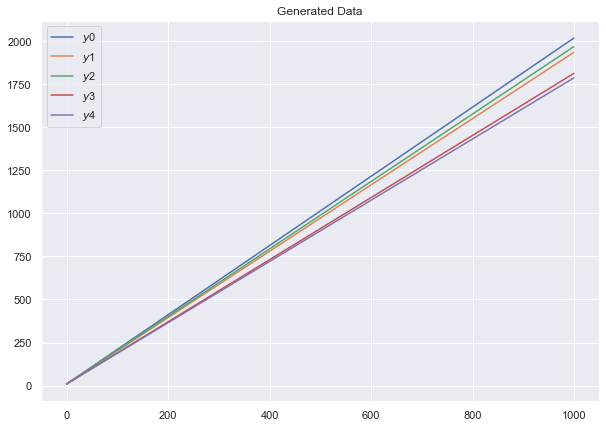

In [4]:
# Generate synthetic data

N = 10  # number of individuals
K = 1000  # number of measurements
y = np.zeros((N,K))

t0 = np.random.normal(
    loc=TARGET_PARAMS["mean_t0"], scale=FIXED_PARAMS["sigma_t0"], size=1)

v0 = np.random.normal(
    loc=TARGET_PARAMS["mean_v0"], scale=FIXED_PARAMS["sigma_v0"], size=1)

p0 = FIXED_PARAMS["p0"]

ksi = np.random.normal(scale=TARGET_PARAMS["sigma_xi"], size=N)
alpha = np.exp(ksi)

tau = np.random.normal(scale=TARGET_PARAMS["sigma_tau"], size=N)

for i in range(K):
    t = alpha * (i - t0 - tau)
    eps = np.random.normal(scale=TARGET_PARAMS["sigma"], size = N)
    y[:,i] = d(t + t0, p0, v0, t0) + eps
    
plt.figure(figsize=(10,7))
for i in range(5):
    plt.plot(np.arange(K), y[i,:] , label = '$y$'+str(i))

plt.title('Generated Data')
plt.legend()
plt.show()

### 1.B – HM-SAEM – Hasting-Metropolis sample

**Question 3** <br><br>

<font color ='red'> 
Propose a Metropolis-Hastings sampler to sample from the a posteriori distribution of the latent
variable $z = (z_{pop}, z_i)_{i \in [1,N]} = (t_0, v_0, \xi_i, \tau_i)_{i \in [1,N]} \in \mathbb{R}^{2N + 2}$.
<br><br>
    
<font color ='black'>     
For the proposal distribution, we consider a multivariate gaussian distribution $\mathcal{N}(z, \sigma_{prop})$ with $z$ being : $z= (z_{pop}, z_i)_{i\in [1, N]}= (t_0, v_0, \xi_i, \tau_i)_{i\in [1, N]} \in \mathbb{R}^{2N+2}$ 
    
<br>
    
<span style="color:blue"> Reference for this question : https://moonbooks.org/Articles/Lalgorithme-de-Metropolis-Hastings-MCMC-avec-python/ </span>

In [5]:
def log_posterior(y, z, p0, t0, t, mean_t0, mean_v0, sigma_t0, sigma_v0, sigma_xi_proposal, sigma_tau_proposal):
    
    t0, v0 = z[0:2]
    xi = z[2:N+2].reshape(-1, 1)  # (N, 1)
    tau = z[N+2:].reshape(-1, 1)  # (N, 1)
    
    ti = np.exp(xi) * (t - t0 - tau)  # (N, K)
    dz = np.sum((y - d(ti + t0, p0, v0, t0)) **2)
    
    pz = (  np.sum(xi ** 2) / (2 * sigma_xi_proposal **  2)
            + np.sum(tau ** 2) / (2 * sigma_tau_proposal ** 2)
            + (t0 - mean_t0) ** 2 / (2 * sigma_t0 ** 2)
            + (v0 - mean_v0) ** 2 / (2 * sigma_v0 ** 2))
    
    return dz, pz


def SRWHM(y, z,p0,mean_t0,mean_v0,sigma_t0,sigma_v0, sigma_xi,sigma_tau,sigma_xi_proposal,sigma_tau_proposal,N,maxiter=10000):

    # proposal distribution : a multivariate gaussian
    mean_prop = [mean_t0, mean_v0] + (2 * N) * [0]
    cov_prop = [sigma_t0, sigma_v0] + [sigma_xi_proposal] * N +  [sigma_tau_proposal] * N
    cov_prop = cov_prop = 0.005 * np.eye(2 * N + 2) * cov_prop
    
    # sample an initial state z0
    z_list = [z]
    t = np.arange(K).reshape(1, -1)  # (1, K)
    
    for k in range(maxiter):

        ################
        # proposal
        ################
        # zk = (t0, v0, alpha_i, tau_i,..)
        # alpha_i : at even positions, starting from position 2
        # tau_i : at odd positions, starting from position 2
        zk = np.random.multivariate_normal(mean=z, cov=cov_prop)
        
        # proposed state - log proba
        dk, pk = log_posterior(y, zk, p0, t0, t, mean_t0, mean_v0, sigma_t0, sigma_v0, sigma_xi_proposal, sigma_tau_proposal)

        # current state - log proba
        d_cur, p_cur = log_posterior(y, z, p0, t0, t, mean_t0, mean_v0, sigma_t0, sigma_v0, sigma_xi_proposal, sigma_tau_proposal)

        # acceptance-rejection
        log_alpha = min(0, dk + pk - d_cur - p_cur)
        log_uk = np.log(np.random.rand())
        
        if log_uk - log_alpha < 0:
            z = zk.copy()
        z_list.append(z)

    return z_list

Initialization of t_0:  0.3026699668206213
Target mean_t0 (to estimate):  0


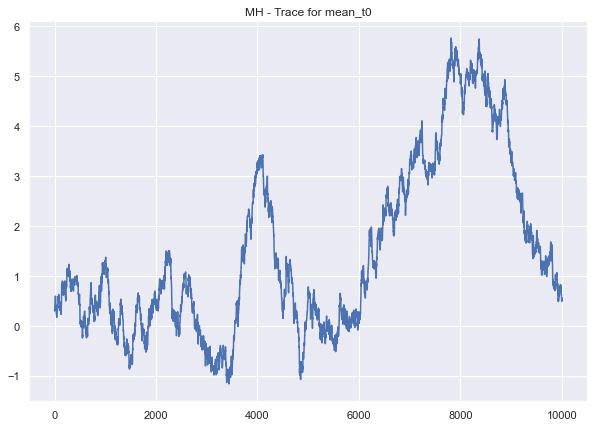

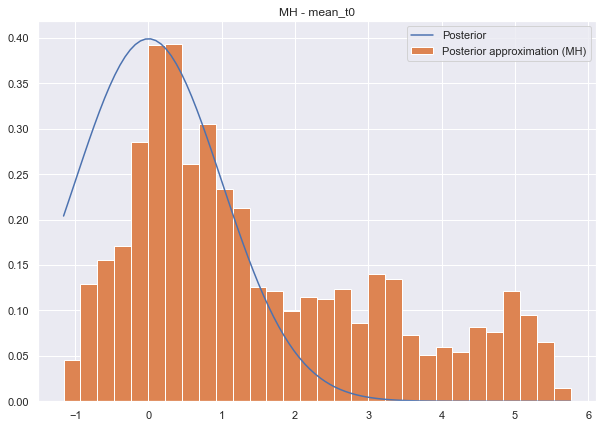

In [7]:
# check the SRWHM for the t0 distribution
z = np.random.random(2 * N + 2)

# Fix some parameters
sigma_xi_sim = 0.1
sigma_tau_sim = 0.1
sigma_xi_proposal = 0.1
sigma_tau_proposal = 0.1
mean_t0_sim = 0
mean_v0_sim = 1

# Estimate the parameters 
z_list = SRWHM(
    y,
    z,
    FIXED_PARAMS["p0"],
    mean_t0_sim,
    mean_v0_sim,
    FIXED_PARAMS["sigma_t0"],
    FIXED_PARAMS["sigma_v0"],
    sigma_xi_sim,
    sigma_tau_sim,
    sigma_xi_proposal,
    sigma_tau_proposal,
    N,
)

t0_list = [z_list[i][0] for i in range(len(z_list))]
mean_t0 = TARGET_PARAMS["mean_t0"]
sigma_t0 = FIXED_PARAMS["sigma_t0"]

print("Initialization of t_0: ", t0_list[0])
print("Target mean_t0 (to estimate): ", mean_t0)

min_t0 = min(t0_list)
max_t0 = max(t0_list)

x_array = np.linspace(min_t0, max_t0, 100)
y_array = np.asarray([stats.norm.pdf(x, loc=mean_t0, scale=sigma_t0) for x in x_array])

######################

plt.figure(figsize=(10,7))
plt.plot(t0_list)
plt.title("MH - Trace for mean_t0")
plt.show()

plt.figure(figsize=(10,7))
plt.plot(x_array, y_array, label="Posterior")
plt.hist(t0_list, bins=30, density=True, stacked=True, label="Posterior approximation (MH)")
plt.title("MH - mean_t0")
plt.legend()
plt.show()

**Interpretation:** 

From the previous result, we can say that the MH converges to values of $t_0$ hallucinating around the real $\overline{t_0}$. Moreover, the posterior approximation of the distribution of $t_0$ is close to the original distribution of $t_0$, which can be seen from the previous histogram. 

**Question 4**<br><br>

<font color ='red'> 
Compute the optimal parameters
$$ \theta^{(k)} = \underset{\theta \in \Theta}{argmax} \{ - \Phi (\theta) + < S_k | \Psi(\theta) >  \}$$ <br>
    
and implement the HM-SAEM in order to find the MAP. In particular, we assume that the MAP
exists. Use the question 2 to check your algorithm.
<br> 
For step-sizes $ \epsilon_k$ we can choose a parameter $N_b$ – burn-in parameter – and define

$$ \forall k \in \mathbb{N} 
\left\{
\begin{array}{ll}
1 & \text{if } ~~ k \in [1,N_b] \\ 
(k - N_b)^{-\alpha} & \text{otherwise} 
\end{array}
\right.
$$
    
where $\alpha \in [\frac{1}{2} , 1[ $ is necessary to ensure the convergence of the MCMC-SAEM.

We have $$q(y,z;\theta) = \exp [−\phi(\theta) + <S(y,z), \psi(\theta)>]$$ where :

 $$ \psi(\theta) = 
  \begin{bmatrix}
  \displaystyle\frac{-KN}{2\sigma^2} \\\\
  \displaystyle\frac{-N}{2\sigma^2_{\xi}} \\\\ 
  \displaystyle\frac{-N}{2\sigma^2_{\tau}} \\\\ 
  \displaystyle\frac{\overline{v_0}}{\sigma^2_{v_0}} \\\\
  \displaystyle\frac{\overline{t_0}}{\sigma^2_{t_0}} \\\\
  \end{bmatrix}  
  \text{,} \quad \Phi(\theta) = 
  \begin{bmatrix}
  (NK+m+2)\log \sigma \\\\
  (N+m_\xi+2)\log \sigma_\xi \\\\
  (N+m_\tau+2)\log \sigma_\tau \\\\ 
  \overline{v_0}^2(\displaystyle\frac{1}{2\sigma_{v_0}^2} + \frac{1}{2s_{v_0}^2}) - \frac{\overline{v_0}\cdot\overline{\overline{v_0}}}{s_{v_0}^2} \\\\
  \overline{t_0}^2(\displaystyle\frac{1}{2\sigma_{t_0}^2} + \frac{1}{2s_{t_0}^2}) - \frac{\overline{t_0}\cdot\overline{\overline{t_0}}}{s_{t_0}^2} \\\\
  \end{bmatrix}$$

$$\theta^k = \text{argmax}_\theta \{-\phi(\theta) + <S^k, \psi(\theta)>\}$$
  
Let's denote $f_k(\theta)=-\phi(\theta) + <S^k, \psi(\theta)>$ at iteration k. The MAP estimator corresponds to $\theta^k$ for which $\nabla_\theta f_k(\theta^k)= 0$

$\begin{aligned}
\nabla_\theta f_k(\theta) &= - \nabla_\theta \phi(\theta) + <S^k, \nabla_\theta \psi(\theta)>\\
&= - \begin{bmatrix}
  (NK+m+2)\displaystyle\frac{1}{\sigma} \\
  (N+m_\xi+2)\displaystyle\frac{1}{\sigma_\xi} \\
  (N+m_\tau+2)\displaystyle\frac{1}{\sigma_\tau} \\
  \overline{v_0}(\displaystyle\frac{1}{\sigma_{v_0}^2} + \frac{1}{s_{v_0}^2}) - \frac{\overline{\overline{v_0}}}{s_{v_0}^2} \\
  \overline{t_0}(\displaystyle\frac{1}{\sigma_{t_0}^2} + \frac{1}{s_{t_0}^2}) - \frac{\overline{\overline{t_0}}}{s_{t_0}^2} \\
  \end{bmatrix} + 
  <S^k, \begin{bmatrix}
  \displaystyle\frac{KN}{\sigma^3} \\
  \displaystyle\frac{N}{\sigma^3_{\xi}} \\
  \displaystyle\frac{N}{\sigma^3_{\tau}} \\
  \displaystyle\frac{1}{\sigma^2_{v_0}} \\
  \displaystyle\frac{1}{\sigma^2_{t_0}} \\
  \end{bmatrix}>
\end{aligned}$

$\nabla_\theta f_k(\theta^k)= 0 \implies \theta^k= \begin{bmatrix}
  \big(\displaystyle\frac{S_5^k}{\sigma^2_{t_0}} +  \frac{\overline{\overline{t_0}}}{s_{t_0}^2}\big)\big(\displaystyle\frac{1}{\sigma_{t_0}^2} + \frac{1}{s_{t_0}^2}\big)^{-1}\\
  \big(\displaystyle\frac{S_4^k}{\sigma^2_{v_0}} + \frac{\overline{\overline{v_0}}}{s_{v_0}^2} \big) \big(\displaystyle\frac{1}{\sigma_{v_0}^2} + \frac{1}{s_{v_0}^2}\big)^{-1} \\
  \displaystyle\sqrt{\frac{N S_2^k}{N+m_\xi+2}} \\
  \displaystyle\sqrt{\frac{N S_3^k}{N+m_\tau+2}} \\
  \displaystyle\sqrt{\frac{KN S_1^k}{NK+m+2}} \\
  \end{bmatrix}$

In [8]:
def update(S,sigma_t0, sigma_v0, mean_mean_t0, mean_mean_v0, st0 , sv0, m_xi , m_tau , m):
    
    t0 = (S[4] / sigma_t0**2) + (mean_mean_t0 / st0**2) / (1/sigma_t0**2 + 1/st0**2)
    v0 = (S[3] / sigma_v0**2) + (mean_mean_v0 / sv0**2) / (1/sigma_v0**2 + 1/sv0**2)
    sigma_xi = np.sqrt((N*S[1])/(N + m_xi + 2))
    sigma_tau = np.sqrt((N*S[2])/(N + m_tau + 2))
    sigma = np.sqrt(K*N*S[0] / (N*K + m + 2))
    
    return [t0, v0, sigma_xi, sigma_tau, sigma]


def S_fct(y,z):
    
    eps = np.exp(z[2:N+2])**2
    S1 = np.sum(eps)/(N*K)
    S2 = np.sum(np.array(z[2:N+2]))/N
    S3 = np.sum(np.array(z[N+3:]))/N

    return np.array([S1, S2, S3, z[1], z[0]])

In [9]:
def HMSAEM(y, nb=20, alpha=0.5, maxiter=1000):

    S = np.array([0] * 5)
    z = (2 * N + 2) * [0]    
    
    mean_t0 = np.random.random()
    mean_v0 = np.random.random()
    
    sigma_t0 = np.random.random()
    sigma_v0 = np.random.random()
    
    
    sigma_xi = TARGET_PARAMS["sigma_xi"]
    sigma_tau = TARGET_PARAMS["sigma_tau"]
        
    st0 = APRIORI_PARAMS["s_t0"]
    sv0 = APRIORI_PARAMS["s_v0"]
    
    m_xi = APRIORI_PARAMS["m_xi"]
    m_tau = APRIORI_PARAMS["m_tau"]
    m = APRIORI_PARAMS["m"]
    
    m_mean_t0 = APRIORI_PARAMS["m_mean_t0"]
    m_mean_v0 = APRIORI_PARAMS["m_mean_v0"]
    
    sigma_xi_proposal = 0.1
    sigma_tau_proposal = 0.1

    for k in range(maxiter):
        
        if k <= nb:
            step_size = 1
        else:
            step_size = (k-nb)**(-alpha)
                   
        # simulation
        z = SRWHM(
                y,
                np.array(z),
                FIXED_PARAMS["p0"],
                mean_t0,
                mean_v0,
                FIXED_PARAMS["sigma_t0"],
                FIXED_PARAMS["sigma_v0"],
                sigma_xi,
                sigma_tau,
                sigma_xi_proposal,
                sigma_tau_proposal,
                N )
        
        z = z[-1]
        # stochastic approximation
        S = S + step_size * (S_fct(y,z) - S) 

        # maximization
        theta = update(S, sigma_t0, sigma_v0, m_mean_t0, m_mean_v0, st0 , sv0, m_xi , m_tau , m )
        
    return theta

In [10]:
## A priori parameters
APRIORI_PARAMS = {
    "m_mean_t0": 0,
    "m_mean_v0": 3,
    "s_t0": 0.01,
    "s_v0": 0.01,
    "v_xi": 1,
    "m_xi": 0.01,
    "v_tau": 1,
    "m_tau": 0.01,
    "v": 1,
    "m": 0.1,
}

theta = HMSAEM(y, nb=20, alpha=0.5, maxiter=1000)
print(theta)

KeyboardInterrupt: 

### 1.C – HMwG-SAEM – Hasting-Metropolis within Gibbs sample


In [11]:
# Fixed parameters
FIXED_PARAMS = {
    "sigma_p0": 2,
    "sigma_t0": 1,
    "sigma_v0": 1,
    "p0": 10,
}

# To estimate
TARGET_PARAMS = {
    "mean_t0": 0,
    "mean_v0": 1,
    "sigma_xi": 0.1,
    "sigma_tau": 0.1,
    "sigma": 0.1 ,
}

## A priori parameters
APRIORI_PARAMS = {
    "m_mean_t0": 0,
    "m_mean_v0": 3,
    "s_t0": 0.01,
    "s_v0": 0.01,
    "v_xi": 1,
    "m_xi": 0.01,
    "v_tau": 1,
    "m_tau": 0.01,
    "v": 1,
    "m": 0.1,
}

## initiatilization
theta_init = {
    "mean_t0": 1,
    "mean_v0": 1,
    "sigma_xi": 0.1,
    "sigma_tau": 0.1,
    "sigma" : 0.1
}

**Question 5** <br>

<font color ='red'> 

Propose a Metropolis-Hastings within Gibbs sampler to sample from the a posteriori distribution
of $z_i = (\xi_i,\tau_i)$. 

In [12]:
def HMwG_zi(y, t0, v0, tau , xi, p0, theta, sigma_sim):
    
    tau_sim = np.zeros(N)
    xi_sim = np.zeros(N)

    # Parameters    
    sigma_tau = theta[0]
    sigma_xi = theta[1]
    
    sim_sigma_tau = sigma_sim[0]
    sim_sigma_xi = sigma_sim[1]
    
    tk = np.arange(K)

    for i in range(N):
        
        yi = y[i, :]

        ###########################
        ## tau simulation (MH step)
        ###########################
        
        # current state
        ti = np.exp(xi[i]) * (tk - t0 - tau[i])
        di = np.sum((yi - d(ti + t0, p0, v0, t0)) ** 2)
        p1 = -(tau[i] / sigma_tau) ** 2 / 2

        # proposal
        tau_proposed = np.random.normal(tau[i], sim_sigma_tau)
        ti = np.exp(xi[i]) * (tk - t0 - tau_proposed)
        di_proposed = np.sum((yi - d(ti + t0, p0, v0, t0)) ** 2)
        p2 = -(tau_proposed / sigma_tau) ** 2 / 2

        # acceptance-rejection
        log_alpha_tau = min( 0 , di_proposed - p1 - di + p2 ) 
        log_u = np.log(np.random.uniform())
        
        if log_u - log_alpha_tau < 0 : 
            tau_sim[i] = tau_proposed
        else:
            tau_sim[i] = tau[i]

        ###########################
        ## xi simulation (MH step)
        ###########################
        
        # current state
        ti = np.exp(xi[i]) * (tk - t0 - tau_sim[i])
        di = np.sum((yi - d(ti + t0, p0, v0, t0)) ** 2)
        p1 = - (xi[i]/ sigma_xi) ** 2 / 2

        # proposal
        xi_proposed = np.random.normal(xi[i], sim_sigma_xi)
        ti = np.exp(xi_proposed) * (tk - t0 - tau_sim[i])
        di_proposed = np.sum((yi - d(ti + t0, p0, v0, t0)) ** 2)
        p2 = - (xi_proposed / sigma_xi) ** 2 / 2

        # acceptance-rejection
        log_alpha_xi = min (0, di_proposed - p1 - di + p2)
        log_u = np.log(np.random.uniform())
        
        if log_u - log_alpha_tau < 0 : 
            xi_sim[i] = xi_proposed
        else:
            xi_sim[i] = xi[i]

            
    return tau_sim, xi_sim

In [13]:
zi = np.random.random((N,2))
tau , xi = zi[:,0] , zi[:,1]

theta = [theta_init["sigma_tau"] , theta_init["sigma_xi"]]
sigma_sim_zi = [0.01,0.01]

for i in range(10000):
    tau , xi = HMwG_zi(y, t0, v0, tau , xi , p0, theta, sigma_sim_zi)
    
print('tau =' , tau )
print('xi =' , xi )

tau = [-39.35419961 -33.5308413  -29.45180545 -38.84151537 -38.40991802
   6.3744442    6.52807436 -38.99733215 -39.57035825  22.44966026]
xi = [ 1.11714879  0.39952013  0.31881121  0.45160635 -0.11675059 -0.75831608
 -1.05675234  0.04385825  0.60300506  0.29179469]


**Question 6** <br>

<font color ='red'> 
Likewise, propose a HMwG sampler for the a posteriori distribution of $z_{pop} = (t_0, v_0)$.
    

In [14]:
def HMwG_zpop(y, t0, v0, tau,xi, p0, sigma_t0, sigma_v0, sigma, theta, sigma_sim):
    
    t0_final = 0
    v0_final = 0
    
    dist = np.zeros((N,K))
    dist_ = np.zeros((N,K))
    
    # Parameters    
    t0_tr = theta[0]
    v0_tr = theta[1]
    
    sim_sigma_t0 = sigma_sim[0]
    sim_sigma_v0 = sigma_sim[1]
    
    # Simulated 
    tk = np.arange(K)
    t0_sim = np.random.normal(loc=t0, scale=sim_sigma_t0, size=1)
    v0_sim = np.random.normal(loc=v0, scale=sim_sigma_v0, size=1)
    
    ###########################
    ## t0 simulation (MH step)
    ###########################
     
    for j in range (K) : 
        t = np.exp(xi)*(tk[j] - t0 - tau) + t0
        dist[:,j] = d(t , p0, v0, t0)

        t_ = np.exp(xi)*(tk[j] - t0_sim - tau ) + t0_sim
        dist_[:,j]= d(t_ , p0, v0, t0_sim)
    
    p1 = - np.sum((y - dist)**2) / (2 * sigma**2 )
    p2 = - np.sum((y - dist_)**2) / (2 * sigma**2 )
    p3 = - np.sum((t0 - t0_tr)**2) / (2 * sigma_t0**2 )
    p4 = - np.sum((t0_sim - t0_tr)**2) / (2 * sigma_t0**2 )
    
    log_alpha = min (0 , - p1 + p2 - p3 + p4)   
    log_u = np.log(np.random.uniform())
        
    if log_u - log_alpha < 0 : 
        t0_final = t0_sim
    else:
        t0_final = t0
    
    ###########################
    ## v0 simulation (MH step)
    ###########################   
    
    for j in range (K) : 
        t = np.exp(xi)*(tk[j] - t0_sim - tau) + t0_sim
        dist[:,j] = d(t , p0, v0, t0_sim)
    
        t_ = np.exp(xi)*(tk[j] - t0_sim - tau ) + t0_sim
        dist_[:,j] = d(t_ , p0, v0_sim, t0_sim)

    p1 = - np.sum((y - dist)**2) / (2 * sigma**2 )
    p2 = - np.sum((y - dist_)**2) / (2 * sigma**2 )
    p3 = - np.sum((v0 - v0_tr)**2) / (2 * sigma_v0**2 )
    p4 = - np.sum((v0_sim - v0_tr)**2) / (2 * sigma_v0**2 )
    
    log_alpha = min (0 , - p1 + p2 - p3 + p4)
    log_u = np.log(np.random.uniform())
        
    if log_u - log_alpha < 0 : 
        v0_final = t0_sim
    else:
        v0_final = v0   
    
    return t0_final , v0_final 

In [15]:
t0_sim , v0_sim = 0, 0 
theta = [theta_init["mean_t0"] ,theta_init["mean_v0"]] 
sigma_sim_pop = [0.01,0.01]

tau = zi[:,0]
xi = zi[:,1]

for i in range(10000):
    t0_sim , v0_sim =  HMwG_zpop(y, t0_sim , v0_sim, tau , xi , p0, 
                                 FIXED_PARAMS["sigma_t0"], FIXED_PARAMS["sigma_v0"], 
                                 TARGET_PARAMS["sigma"], theta, sigma_sim_pop)
    
print('The true t0 = ' , t0)
print('The estiamted t0 = ' , t0_sim)
print('The true v0 = ' , v0)
print('The estiamted v0 = ' , v0_sim)

The true t0 =  [0.44462104]
The estiamted t0 =  [-0.00343488]
The true v0 =  [2.05993246]
The estiamted v0 =  [-0.00343488]


**Question 7**<br>

<font color ='red'> 
Implement the HMwG-SAEM in order to find the MAP.

In [16]:
def HMwG_SAEM(y,FIXED_PARAMS,APRIORI_PARAMS,theta_init,sigma_sim_zi,sigma_sim_pop,maxiter=100, nb= 20):
    
    # parameters
    p0 = FIXED_PARAMS["p0"]
    sigma_t0 = FIXED_PARAMS["sigma_t0"]
    sigma_v0 = FIXED_PARAMS["sigma_v0"]
    mm_t0 = APRIORI_PARAMS["m_mean_t0"]
    mm_v0 = APRIORI_PARAMS["m_mean_v0"]
    s_t0 = APRIORI_PARAMS["s_t0"]
    s_v0 = APRIORI_PARAMS["s_v0"]
    v_xi = APRIORI_PARAMS["v_xi"]
    m_xi = APRIORI_PARAMS["m_xi"]
    v_tau = APRIORI_PARAMS["v_tau"]
    m_tau = APRIORI_PARAMS["m_tau"]
    v = APRIORI_PARAMS["v"]
    m = APRIORI_PARAMS["m"]
    
    sigma_ = TARGET_PARAMS["sigma"]
    theta1 = [theta_init["sigma_tau"] , theta_init["sigma_xi"]]
    theta2 = [theta_init["mean_t0"] ,theta_init["mean_v0"]] 

    # initialization
    tau = np.zeros(N)
    xi = np.zeros(N)
    t0 = 0.0
    v0 = 2.0
    di = np.zeros((N, K))
    S1, S2, S3, S4, S5 = 0, 0, 0, 0, 0

    # burn-in period
    for i in range(int(maxiter / 2)):
        tau , xi = HMwG_zi(y, t0, v0, tau, xi, p0, theta1, sigma_sim_zi)
        t0, v0 = HMwG_zpop(y, t0, v0, tau, xi,p0, sigma_t0, sigma_v0, sigma_, theta2, sigma_sim_pop)

    # simulation
    for i in range(int(maxiter / 2)):
        tau , xi = HMwG_zi(y, t0, v0, tau, xi, p0, theta1, sigma_sim_zi)
        t0, v0 = HMwG_zpop(y, t0, v0, tau, xi, p0, sigma_t0, sigma_v0, sigma_, theta2, sigma_sim_pop)

        for k in range(K):
            tk = np.exp(xi) * (k - t0 - tau)
            di[:, k] = d(tk + t0, p0, v0, t0)

        if i < nb:
            eps_k = 1
        else:
            eps_k = (i + 1 - nb) ** (-0.65)

        S1_ = S1 + eps_k * (np.sum((y - di) ** 2) / (1.0 * K * N) - S1)
        S2_ = S2 + eps_k * (np.mean(xi ** 2) - S2)
        S3_ = S3 + eps_k * (np.mean(tau ** 2) - S3)
        S4_ = S4 + eps_k * (v0 - S4) 
        S5_ = S5 + eps_k * (t0 - S5)

        # optimization
        mean_t0 = (S4_ / (sigma_t0 ** 2) + mm_t0 / (s_t0 ** 2)) / (
            ((1.0 / sigma_t0) ** 2 + (1.0 / s_t0) ** 2))
        
        mean_v0 = (S3_ / (sigma_v0 ** 2) + mm_v0 / (s_v0 ** 2)) / (
            (1.0 / sigma_v0) ** 2 + (1.0 / s_v0) ** 2)

        sigma_xi = np.sqrt(N * S2_ / (N*K + m + 2))
        sigma_tau = np.sqrt((N * S3_ ) / (N + m_tau+2))
        sigma = np.sqrt((K * N * S5_) / (N*K + m +2))

        theta = {
            "mean_t0": mean_t0,
            "mean_v0": mean_v0,
            "sigma_xi": sigma_xi,
            "sigma_tau": sigma_tau,
            "sigma": sigma}

        # update
        S1 = S1_
        S2 = S2_
        S3 = S3_
        S4 = S4_
        S5 = S5_
        
    return theta

In [17]:
theta_model = HMwG_SAEM(
    y,
    FIXED_PARAMS,
    APRIORI_PARAMS,
    theta_init,
    sigma_sim_zi,
    sigma_sim_pop,
    maxiter=100,
    nb = 20
)

for k in theta_model.keys():
    print(k , ':  ' , theta_model[k])

mean_t0 :   [2.75938109e-07]
mean_v0 :   2.9997004260087072
sigma_xi :   0.0019291948626381915
sigma_tau :   0.057425425563807087
sigma :   [0.04697248]


**Interpretation:** 

The results are close to the original parameters. If we increase the number of iterations, the algorithm will converge to closer results. 

**Question 8**<br>

<font color ='red'> 
Explain what is the advantages of a Block Gibbs sampler over a "one-at-a-time" Gibbs sampler
for our model.

**Question 9**<br>

<font color ='red'> 
Implement a Block HMwG sampler by choosing a block for the fixed effects and a block by
individuals.

## Exercise 2: Multiplicative Hasting-Metropolis

**Question 1:** <br>

<font color ='red'> 
Determine the density of the jumping distribution $Y ∼ q(X, Y)$

In this question, we will determine the jumping distribution $Y \sim q(X,Y)$. 

We have: if $B = 1$, we set $Y = \epsilon X$. Otherwise, we set $Y = \frac{X}{\epsilon}$. Then, we accept the candidate $Y$ with a probability given by $α(X, Y )$, the usual Hasting-Metropolis acceptation ratio.

Let's denote, $h(y)$ a measurable and bounded function.

$
\begin{aligned}
E[h(Y)]
& = E[h(Y)|B=1]P(B=1) + E[h(Y)|B=0] P(B=0)\\
& = E[h(\epsilon X)|B=1]P(B=1) + E[h(\frac{X}{\epsilon})|B=0] P(B=0)\\
& =\frac{1}{2} \int_{-1}^{1} h(\epsilon X) f(\epsilon) d\epsilon + \frac{1}{2} \int_{-1}^{1} h(\frac{X}{\epsilon}) f(\epsilon) d\epsilon \\
& =\frac{1}{2} \int_{-1}^{1} h(\epsilon X) f(\epsilon) d\epsilon + \frac{1}{2} \int_{-1}^{0} h(\frac{X}{\epsilon}) f(\epsilon) d\epsilon + \frac{1}{2} \int_{0}^{1} h(\frac{X}{\epsilon}) f(\epsilon) d\epsilon \\
\end{aligned}
$

We will take: $Y = \epsilon X $ in the first integral and $Y = \frac{X}{\epsilon}$ in the second and third integrals. 

Thus, 

- for $X>0$: 
$
\begin{aligned}
E[h(Y)]
& = \frac{1}{2} \int_{-X}^{X} h(Y) f(\frac{Y}{X}) \frac{dY}{X} + \frac{1}{2} \int_{-\infty}^{-X} h(Y) f(\frac{X}{Y}) \frac{X}{Y^2}dY + \frac{1}{2} \int_{X}^{+ \infty} h(Y) f(\frac{X}{Y}) \frac{X}{Y^2}dY  \\
\end{aligned}
$

- for $X<0$:
$
\begin{aligned}
E[h(Y)]
& = -\frac{1}{2} \int_{X}^{-X} h(Y) f(\frac{Y}{X}) \frac{dY}{X} - \frac{1}{2} \int_{-X}^{+\infty} h(Y) f(\frac{X}{Y}) \frac{X}{Y^2}dY -  \frac{1}{2} \int_{- \infty}^{X} h(Y) f(\frac{X}{Y}) \frac{X}{Y^2}dY  \\
\end{aligned}
$<br>
$\implies \text{If}~~ X \neq 0: q(X,Y)= \frac{1}{2} \frac{f(\frac{Y}{X})}{|X|} \mathbb{1}_{]-|X|,|X|[}+\frac{1}{2} f(\frac{X}{Y}) \frac{|X|}{Y^2} \mathbb{1}_{[-\infty,-|X|[} + \frac{1}{2}  f(\frac{X}{Y}) \frac{|X|}{Y^2} \mathbb{1}_{[|X|,\infty[}$
<br>
- for $X = 0$: $E[h(0)]=h(0)$


In the next part, we will take $X \neq 0$ and we will choose the density of $\epsilon$ equal to zero when we get 0 for value. In other words, we will only work on the case when $X \neq 0$. Thus, we can say that : 

$$\begin{aligned} q(X,Y)
& = \frac{1}{2} \frac{f(\frac{Y}{X})}{|X|} \mathbb{1}_{]-|X|,|X|[}+\frac{1}{2} f(\frac{X}{Y}) \frac{|X|}{Y^2} \mathbb{1}_{[-\infty,-|X|[} + \frac{1}{2}  f(\frac{X}{Y}) \frac{|X|}{Y^2} \mathbb{1}_{[|X|,\infty[} \\
& =  \frac{1}{2} \frac{f(\frac{Y}{X})}{|X|} \mathbb{1}_{|Y|<|X|}+\frac{1}{2} f(\frac{X}{Y}) \frac{|X|}{Y^2} \mathbb{1}_{|Y|>|X|} \\
\end{aligned}
$$

**Question 2:** <br>

<font color ='red'> 

Compute the acceptation ratio $\alpha$ so that the chain has a given distribution $\pi$ as invariant distribution.

The acceptation ratio is equal to: 

$
\begin{aligned}
\alpha (X,Y) 
& = min (1,\frac{q(Y, X)\pi(Y)}{q(X,Y)\pi(X)} \\
& = min (1, \frac { \{ \frac{1}{2} \frac{f(\frac{X}{Y})}{|Y|} \mathbb{1}_{|X|<|Y|}+\frac{1}{2} f(\frac{Y}{X}) \frac{|Y|}{X^2} \mathbb{1}_{|X|>|Y|} \} ~~~\pi(Y)} {\{\frac{1}{2} \frac{f(\frac{Y}{X})}{|X|} \mathbb{1}_{|Y|<|X|}+\frac{1}{2} f(\frac{X}{Y}) \frac{|X|}{Y^2} \mathbb{1}_{|Y|>|X|} \} ~~~ \pi(X) } ) \\
& = min (1, \frac { \frac {|Y|}{|X|} \{ \frac{1}{2} f(\frac{X}{Y}) \frac{|X|}{Y^2} \mathbb{1}_{|X|<|Y|}+ \frac{1}{2} \frac{f(\frac{Y}{X})}{|X|} \mathbb{1}_{|X|>|Y|}\}    ~~~ \pi(Y)  }{\{\frac{1}{2} \frac{f(\frac{Y}{X})}{|X|} \mathbb{1}_{|Y|<|X|}+\frac{1}{2} f(\frac{X}{Y}) \frac{|X|}{Y^2} \mathbb{1}_{|Y|>|X|} \} ~~~\pi(X)} \\
& = min (1, \frac {|Y| \pi(Y) }{|X|\pi(X)} )
\end{aligned}
$



**Question 3 & 4:** <br>

<font color ='red'> 

- Implement this sampler for two different target distributions : the first one being a distribution
from which we can sample using the inverse transform method and the second one is of your
choice.<br><br> 

- Evaluate, in each case, the match of your samples with the true distribution.

In this part, I used the uniform distribution in the interval of $]-1,1[$ to generate $\epsilon$. The first distribution I will use is the exponential distribution from which we can sample using the inverse transformation method and the second distribution is the Gaussian distribution. 

In [18]:
def HM(x0,N,distribution,m,sig):
    
    x = [x0]
    X = x0
    
    for i in range(N):
        e = np.random.uniform(-1,1)
        B = np.round(np.random.random())
        Y = e*X*B + X/e*np.abs(1-B) 
        
        if distribution=="exponential":
            pi_y = sp.stats.expon.pdf(Y,m,sig)
            pi_x = sp.stats.expon.pdf(X,m,sig)
        
        if distribution=="normal":
            pi_y = sp.stats.norm.pdf(Y,m,sig)
            pi_x = sp.stats.norm.pdf(X,m,sig)
        
        u = np.random.random() 
        alpha = min (1, (pi_y/pi_x)*(np.abs(Y)/np.abs(X)))
        
        if u < alpha :
            x.append(Y)
            X = Y 
        
    return(x)

####  Exponential distribution

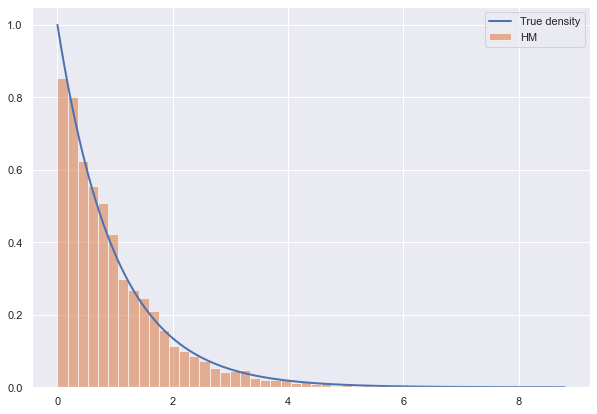

In [19]:
FIXED_PARAMS={
  'x0':1,
  'N':10000,
  'm':0,
  'sig':1,
  'distribution':"exponential"
}

# Simulated density 
x_sim = HM(FIXED_PARAMS["x0"],
           FIXED_PARAMS["N"],
           FIXED_PARAMS["distribution"],
           FIXED_PARAMS["m"],
           FIXED_PARAMS["sig"]
)

# True density
x = np.linspace(min(x_sim),max(x_sim),1000)
exp = sp.stats.expon.pdf(x,FIXED_PARAMS["m"],FIXED_PARAMS["sig"])

plt.figure(figsize=(10,7))
plt.plot(x , exp , linewidth = 2 , label = 'True density')
plt.hist(x_sim , bins = 50 , density = True , alpha=0.6 , label = 'HM')

plt.legend()
plt.show()

#### Gaussian distribution

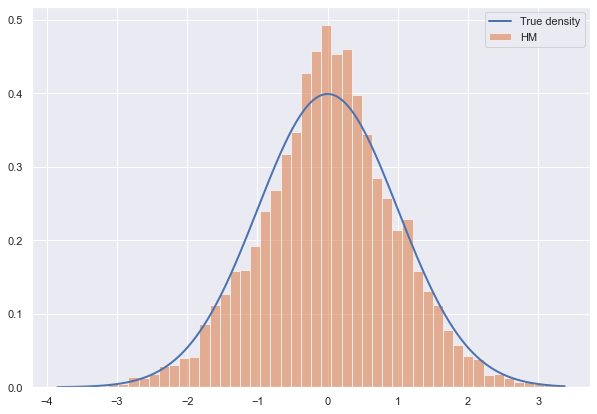

In [20]:
FIXED_PARAMS={
  'x0':1,
  'N':10000,
  'm':0,
  'sig':1,
  'distribution':"normal"
}

# Simulated density 
x_sim = HM(FIXED_PARAMS["x0"],
           FIXED_PARAMS["N"],
           FIXED_PARAMS["distribution"],
           FIXED_PARAMS["m"],
           FIXED_PARAMS["sig"]
)

# True density
x = np.linspace(min(x_sim),max(x_sim),1000)
exp = sp.stats.norm.pdf(x,FIXED_PARAMS["m"],FIXED_PARAMS["sig"])

plt.figure(figsize=(10,7))
plt.plot(x , exp , linewidth = 2 , label = 'True density')
plt.hist(x_sim , bins = 50 , density = True , alpha=0.6 , label = 'HM')

plt.legend()
plt.show()

**Interpretation:** <br><br>
From the previous results, we found that the multiplicative MH is able to correctly approximlate the distribution in both cases. The histogram results are very close to the true distribution. 
